In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp

import context
from samplers.sgld import sgld_jaxloop, sgld_adam_time_budget
from samplers.sgldcv import sgld_jaxloop_CV
from samplers.sghmc import sghmc_scan, sghmc_time_budget
from samplers.mala import mala_sampler

import numpyro
from numpyro.infer import NUTS, MCMC

from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed

# LR uncertainty metrics

### estimate standard deviation

sgld: 5 seconds
    
- SH 1: 0.0985
- SH 2: 0.0871
- SH 3: 0.2936
- SH concat: 0.1514
- default: 0.1649
- adam: 0.6945

sgld-CV: 5 seconds

- SH 1: 0.0436
- SH 2: 0.0985
- SH 3: 0.0417
- SH concat: 0.0598
- default: 0.0556

sghmc: 10 seconds
- SH 1: 0.0326
- SH 2: 0.0710
- SH 3: 0.0702
- SH concat: 0.0646
- default: 0.0535


### estimate KSD

sgld: KSD:

- SH 1: 10.2799
- SH 2: 9.6337
- SH 3: 11.8168
- default: 17.6134
- adam: 23.0215

sgldCV: KSD:

- SH 1: 2.1778
- SH 2: 3.2645
- SH 3: 2.7485
- default: 7.2116

sghmc: KSD:

- SH 1: 7.3113
- SH 2: 8.4710
- SH 3: 6.7539
- default: 8.8292


In [2]:


from examples.logistic_regression.logistic_regression_model import gen_data_and_log_post
from samplers.sgld import sgld, sgld_jaxloop, sgld_time_budget
from samplers.sgldcv import sgld_time_budget_CV


dim = 10
Ndata = 100000
key = random.PRNGKey(0) # same key as 'LR-evaluate_default_vs_KSD.ipynb'
theta_true, X, y_data, val_and_grad_log_post = gen_data_and_log_post(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
del X, y_data


@jit
def fb_val_and_grad_lp(theta):
    return val_and_grad_log_post(theta, X_train, y_train)


def grad_lp_LR_fb(theta):
    return val_and_grad_log_post(theta, X_train, y_train)[1]

@jit
def fb_val_and_grad_lp(theta):
    return val_and_grad_log_post(theta, X_train, y_train)

batch_grad_lp_LR_fb = jit(vmap(grad_lp_LR_fb))

@jit
def potential_log_reg(theta):
    return -val_and_grad_log_post(theta, X_train, y_train)[0]


def get_fb_grads_batches(samples, calc_batch_size):
    """
    Calculate the fullbatch gradients, but in batches
    """
    list_grads = []
    len_sgld = samples.shape[0]
    num_steps = int(np.ceil(len_sgld/calc_batch_size))
    for i in range(num_steps):
        new_grads = batch_grad_lp_LR_fb(samples[i*calc_batch_size:(i+1)*calc_batch_size])
        wait_until_computed(new_grads)
        list_grads.append(new_grads)
    fb_grads = jnp.concatenate(list_grads, axis=0)
    return fb_grads


def accuracy(samples, X, y):

    def predict(theta, x_val):
        return -logsumexp(jnp.array([0., -jnp.dot(theta, x_val)]))

    batch_predict_params = jit(vmap(predict, in_axes=(0, None)))

    def _accuracy(samples, x_val, y_val):
        pred = jnp.round(jnp.exp(jnp.mean(batch_predict_params(samples, x_val))), 0)
        return jnp.array(pred == y_val, dtype=jnp.int32)
    
    batch_accuracy = vmap(_accuracy, in_axes=(None, 0,0))
    return jnp.mean(batch_accuracy(samples, X, y))


generating data, with N=100000 and dim=10


### run NUTS for 20K iterations

- ESS = 6759
- Takes 4 minutes to run
- predictive accuracy: 93.71

In [10]:
# nuts_sampler = MCMC(NUTS(potential_fn=potential_log_reg), num_samples=20000, 
#                  num_warmup=1000, num_chains=1, progress_bar=False)


# init_params = jnp.zeros(theta_true.shape[0])
    
# starttime = time.time()
# key = random.PRNGKey(0)
# nuts_sampler.run(key, init_params=init_params)

# samples_nuts = nuts_sampler.get_samples(True)
# wait_until_computed(samples_nuts)
# endtime = time.time()
# print(f"Running time: {endtime-starttime:.2f} sec")

# samples_nuts = samples_nuts[0]

Running time: 249.12 sec


Maximum IATL 3.0


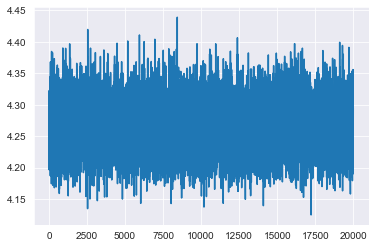

In [11]:
# from emcee.autocorr import integrated_time

# max_IAT = max([integrated_time(samples_nuts[:,idx], tol=100) for idx in range(10)])[0]
# print(f"Maximum IATL {max_IAT:.1f}")


# plt.plot(samples_nuts[:,0])

In [12]:
20000/max_IAT

6759.939627094715

In [123]:
print(accuracy(samples_nuts,X_test, y_test))

0.9371


In [13]:
NUTS_stds = samples_nuts.std(axis=0)

print(NUTS_stds)

[0.03785377 0.01756924 0.02984989 0.01798336 0.03235544 0.02080127
 0.0369044  0.01981673 0.01966911 0.04595855]


In [3]:
# np.savetxt("outputs/LR_uncertainty_tests/NUTS_stds.txt", NUTS_stds)

NUTS_stds = np.genfromtxt("outputs/LR_uncertainty_tests/NUTS_stds.txt")

In [4]:
def get_relative_error_LR(estimate, ground_truth=NUTS_stds):
    return np.linalg.norm(estimate - ground_truth)/np.linalg.norm(ground_truth)



# SGLD

Run sgld for SH and default parameters. Also run sgld-adam

In [5]:
def run_sgld_sampler(key, time_budget, log_dt, b_s_r):
    dt = 10**(log_dt)
    batch_size = int(X_train.shape[0]*b_s_r)
    x_0 = theta_true
    samples, _ = sgld_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                                                   time_budget, dt, batch_size, x_0)
    return samples

time_budget = 5
key = random.PRNGKey(0)

In [6]:
logdt1 = -4.51
b_s_r1 = 0.053
samples_sgld1 = run_sgld_sampler(key, time_budget, logdt1, b_s_r1)

logdt2 = -4.80
b_s_r2 = 0.040
samples_sgld2 = run_sgld_sampler(key, time_budget, logdt2, b_s_r2)

logdt3 = -3.96
b_s_r3 = 0.071
samples_sgld3 = run_sgld_sampler(key, time_budget, logdt3, b_s_r3)

In [7]:
samples_sgld_concat = np.concatenate([samples_sgld1, samples_sgld2, samples_sgld3,])

In [8]:
log_dt, b_s_r = -4.8, 0.1
key = random.PRNGKey(0)
samples_sgld_default = run_sgld_sampler(key, time_budget, log_dt, b_s_r)

In [9]:
key = random.PRNGKey(0)
dt = 10**(-1.)
batch_size = int(X_train.shape[0]*0.1)
x_0 = theta_true
samples_adam, _ = sgld_adam_time_budget(key, val_and_grad_log_post, X_train, y_train, time_budget, 
                                        dt, batch_size, theta_true)

In [10]:
std_error_sgld_SH1 = get_relative_error_LR(samples_sgld1.std(axis=0))
std_error_sgld_SH2 = get_relative_error_LR(samples_sgld2.std(axis=0))
std_error_sgld_SH3 = get_relative_error_LR(samples_sgld3.std(axis=0))

std_error_sgld_SH_concat = get_relative_error_LR(samples_sgld_concat.std(axis=0))

std_error_sgld_default = get_relative_error_LR(samples_sgld_default.std(axis=0))

std_error_sgld_adam = get_relative_error_LR(samples_adam.std(axis=0))




### calculate KSD

In [11]:
def get_ksd_from_samples(samples):
    fb_grads = get_fb_grads_batches(samples, 1000)
    est_ksd = imq_KSD(samples, fb_grads)
    return est_ksd

In [12]:

print("SH1:")
est_ksd_sgld_1 = get_ksd_from_samples(samples_sgld1)
print(f"{est_ksd_sgld_1:.2f}")

print("SH2:")
est_ksd_sgld_2 = get_ksd_from_samples(samples_sgld2)
print(f"{est_ksd_sgld_2:.2f}")

print("SH3:")
est_ksd_sgld_3 = get_ksd_from_samples(samples_sgld3)
print(f"{est_ksd_sgld_3:.2f}")

print("Concatenated SH:")
est_ksd_sgld_concat = get_ksd_from_samples(samples_sgld_concat)
print(f"{est_ksd_sgld_concat:.2f}")


print("default:")
est_ksd_sgld_default = get_ksd_from_samples(samples_sgld_default)
print(f"{est_ksd_sgld_default:.2f}")

print("adam:")
est_ksd_sgld_adam = get_ksd_from_samples(samples_adam)
print(f"{est_ksd_sgld_adam:.2f}")


SH1:
10.73
SH2:
6.92
SH3:
11.72
Concatenated SH:
6.22
default:
18.17
adam:
23.28


In [13]:
samples_sgld_concat.shape

(54086, 10)

#### predictive accuracy

In [14]:
acc_sgld_SH1 = accuracy(samples_sgld1, X_test, y_test)
acc_sgld_SH2 = accuracy(samples_sgld2, X_test, y_test)
acc_sgld_SH3 = accuracy(samples_sgld3, X_test, y_test)
acc_sgld_SH_concat = accuracy(samples_sgld_concat, X_test, y_test)

acc_sgld_default = accuracy(samples_sgld_default, X_test, y_test)
acc_sgld_adam = accuracy(samples_adam, X_test, y_test)


In [15]:
print("sgld: Number of samples:\n")

print(f"SH 1: {len(samples_sgld1)}")
print(f"SH 2: {len(samples_sgld2)}")
print(f"SH 3: {len(samples_sgld3)}")
print(f"SH concat: {len(samples_sgld_concat)}")

print(f"default: {len(samples_sgld_default)}")
print(f"adam: {len(samples_adam)}")


sgld: Number of samples:

SH 1: 16525
SH 2: 21687
SH 3: 15874
SH concat: 54086
default: 12370
adam: 12660


In [16]:
# time budget = 5
print("sgld: Relative errors:\n")

print(f"SH 1: {std_error_sgld_SH1:.4f}")
print(f"SH 2: {std_error_sgld_SH2:.4f}")
print(f"SH 3: {std_error_sgld_SH3:.4f}")
print(f"SH concat: {std_error_sgld_SH_concat:.4f}")

print(f"default: {std_error_sgld_default:.4f}")
print(f"adam: {std_error_sgld_adam:.4f}")



sgld: Relative errors:

SH 1: 0.0984
SH 2: 0.0819
SH 3: 0.2912
SH concat: 0.1449
default: 0.1648
adam: 0.6877


In [17]:
# time budget = 5
print("sgld: KSD:\n")

print(f"SH 1: {est_ksd_sgld_1:.4f}")
print(f"SH 2: {est_ksd_sgld_2:.4f}")
print(f"SH 3: {est_ksd_sgld_3:.4f}")
print(f"SH concat: {est_ksd_sgld_concat:.4f}")

print(f"default: {est_ksd_sgld_default:.4f}")
print(f"adam: {est_ksd_sgld_adam:.4f}")



sgld: KSD:

SH 1: 10.7328
SH 2: 6.9197
SH 3: 11.7162
SH concat: 6.2212
default: 18.1680
adam: 23.2768


In [18]:
# time budget = 5
print("sgld: predictive accuracy:\n")

print(f"SH 1: {acc_sgld_SH1:.4f}")
print(f"SH 2: {acc_sgld_SH2:.4f}")
print(f"SH 3: {acc_sgld_SH3:.4f}")

print(f"SH concat: {acc_sgld_SH_concat:.4f}")

print(f"default: {acc_sgld_default:.4f}")
print(f"adam: {acc_sgld_adam:.4f}")



sgld: predictive accuracy:

SH 1: 0.9370
SH 2: 0.9371
SH 3: 0.9372
SH concat: 0.9371
default: 0.9371
adam: 0.9372


# sgld-CV

In [22]:
def run_sgldCV_sampler(key, time_budget, log_dt, b_s_r):
    dt = 10**(log_dt)
    batch_size = int(X_train.shape[0]*b_s_r)
    x_0 = theta_true
    samples, _ = sgld_time_budget_CV(key, val_and_grad_log_post, 
              X_train, y_train, time_budget, dt, batch_size, x_0, x_0)
    return samples


time_budget = 5
key = random.PRNGKey(0)

logdt1 = -3.81
b_s_r1 = 0.01
samples_sgldCV1 = run_sgldCV_sampler(key, time_budget, logdt1, b_s_r1)

logdt2 = -3.80
b_s_r2 = 0.0014
samples_sgldCV2 = run_sgldCV_sampler(key, time_budget, logdt2, b_s_r2)

logdt3 = -3.99
b_s_r3 = 0.0046
samples_sgldCV3 = run_sgldCV_sampler(key, time_budget, logdt3, b_s_r3)


samples_sgldCV_concat = np.concatenate([samples_sgldCV1, samples_sgldCV2, samples_sgldCV3,])

In [23]:
logdt1 = -4.2
b_s_r1 = 0.1
samples_sgldCV_default = run_sgldCV_sampler(key, time_budget, logdt1, b_s_r1)

In [24]:
std_error_sgldCV_SH1 = get_relative_error_LR(samples_sgldCV1.std(axis=0))
std_error_sgldCV_SH2 = get_relative_error_LR(samples_sgldCV2.std(axis=0))
std_error_sgldCV_SH3 = get_relative_error_LR(samples_sgldCV3.std(axis=0))

std_error_sgldCV_SH_concat = get_relative_error_LR(samples_sgldCV_concat.std(axis=0))

std_error_sgldCV_default = get_relative_error_LR(samples_sgldCV_default.std(axis=0))




#### calculate KSD

In [25]:

print("SH1:")
est_ksd_sgldCV_1 = get_ksd_from_samples(samples_sgldCV1)
print(f"{est_ksd_sgldCV_1:.2f}")

print("SH2:")
est_ksd_sgldCV_2 = get_ksd_from_samples(samples_sgldCV2)
print(f"{est_ksd_sgldCV_2:.2f}")

print("SH3:")
est_ksd_sgldCV_3 = get_ksd_from_samples(samples_sgldCV3)
print(f"{est_ksd_sgldCV_3:.2f}")

print("concat:")
est_ksd_sgldCV_concat = get_ksd_from_samples(samples_sgldCV_concat)
print(f"{est_ksd_sgldCV_concat:.2f}")


print("default:")
est_ksd_sgldCV_default = get_ksd_from_samples(samples_sgldCV_default)
print(f"{est_ksd_sgldCV_default:.2f}")


SH1:
2.57
SH2:
3.13
SH3:
2.89
concat:
2.60
default:
9.36


#### predictive accuracy

In [26]:
acc_sgldCV_SH1 = accuracy(samples_sgldCV1, X_test, y_test)
acc_sgldCV_SH2 = accuracy(samples_sgldCV2, X_test, y_test)
acc_sgldCV_SH3 = accuracy(samples_sgldCV3, X_test, y_test)

acc_sgldCV_SH_concat = accuracy(samples_sgldCV_concat, X_test, y_test)

acc_sgldCV_default = accuracy(samples_sgldCV_default, X_test, y_test)



In [31]:
print("sgldCV: Number of samples:\n")

print(f"SH 1: {len(samples_sgldCV1)}")
print(f"SH 2: {len(samples_sgldCV2)}")
print(f"SH 3: {len(samples_sgldCV3)}")
print(f"SH concat: {len(samples_sgldCV_concat)}")

print(f"default: {len(samples_sgldCV_default)}")


sgldCV: Number of samples:

SH 1: 23604
SH 2: 22585
SH 3: 24533
SH concat: 70722
default: 8681


In [28]:
# time budget = 5
print("SGLD-CV, relative errors:\n")

print(f"SH 1: {std_error_sgldCV_SH1:.4f}")
print(f"SH 2: {std_error_sgldCV_SH2:.4f}")
print(f"SH 3: {std_error_sgldCV_SH3:.4f}")

print(f"SH concat: {std_error_sgldCV_SH_concat:.4f}")

print(f"default: {std_error_sgldCV_default:.4f}")



SGLD-CV, relative errors:

SH 1: 0.0400
SH 2: 0.0883
SH 3: 0.0333
SH concat: 0.0529
default: 0.1196


In [29]:
# time budget = 5
print("sgldCV: KSD:\n")

print(f"SH 1: {est_ksd_sgldCV_1:.4f}")
print(f"SH 2: {est_ksd_sgldCV_2:.4f}")
print(f"SH 3: {est_ksd_sgldCV_3:.4f}")

print(f"SH concat: {est_ksd_sgldCV_concat:.4f}")

print(f"default: {est_ksd_sgldCV_default:.4f}")



sgldCV: KSD:

SH 1: 2.5715
SH 2: 3.1323
SH 3: 2.8892
SH concat: 2.6009
default: 9.3629


In [30]:
# time budget = 5
print("sgldCV: predictive accuracy:\n")

print(f"SH 1: {acc_sgldCV_SH1:.4f}")
print(f"SH 2: {acc_sgldCV_SH2:.4f}")
print(f"SH 3: {acc_sgldCV_SH3:.4f}")

print(f"SH concat: {acc_sgldCV_SH_concat:.4f}")

print(f"default: {acc_sgldCV_default:.4f}")



sgldCV: predictive accuracy:

SH 1: 0.9371
SH 2: 0.9371
SH 3: 0.9371
SH concat: 0.9371
default: 0.9370


# sghmc

In [33]:
def run_sghmc_sampler(key, time_budget, log_dt, b_s_r, L):
    dt = 10**(log_dt)
    batch_size = int(X_train.shape[0]*b_s_r)
    x_0 = theta_true
    alpha = 0.01
    samples, _ = sghmc_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                           time_budget, dt, batch_size, x_0, alpha, L)
    return samples

In [34]:
time_budget = 10
alpha = 0.01

key = random.PRNGKey(0)

In [35]:
logdt1, b_s_r1, L1 = -6.63, 0.045, 24
samples_sghmc1 = run_sghmc_sampler(key, time_budget, logdt1, b_s_r1, L1)

logdt2, b_s_r2, L2 = -6.58, 0.014, 14
samples_sghmc2 = run_sghmc_sampler(key, time_budget, logdt2, b_s_r2, L2)

logdt3, b_s_r3, L3 = -5.96, 0.073, 15
samples_sghmc3 = run_sghmc_sampler(key, time_budget, logdt3, b_s_r3, L3)


In [36]:
samples_sghmc_concat = np.concatenate([samples_sghmc1, samples_sghmc2, samples_sghmc3,])


In [37]:
logdt, b_s_r, L = -6, 0.1, 11
samples_sghmc_default = run_sghmc_sampler(key, time_budget, logdt, b_s_r, L)


In [38]:
std_error_sghmc_SH1 = get_relative_error_LR(samples_sghmc1.std(axis=0))
std_error_sghmc_SH2 = get_relative_error_LR(samples_sghmc2.std(axis=0))
std_error_sghmc_SH3 = get_relative_error_LR(samples_sghmc3.std(axis=0))

std_error_sghmc_SH_concat = get_relative_error_LR(samples_sghmc_concat.std(axis=0))

std_error_sghmc_default = get_relative_error_LR(samples_sghmc_default.std(axis=0))




#### calculate KSD

In [40]:

print("SH1:")
est_ksd_sghmc_1 = get_ksd_from_samples(samples_sghmc1)
print(f"{est_ksd_sghmc_1:.2f}")

print("SH2:")
est_ksd_sghmc_2 = get_ksd_from_samples(samples_sghmc2)
print(f"{est_ksd_sghmc_2:.2f}")

print("SH3:")
est_ksd_sghmc_3 = get_ksd_from_samples(samples_sghmc3)
print(f"{est_ksd_sghmc_3:.2f}")


print("SH_concat:")
est_ksd_sghmc_concat = get_ksd_from_samples(samples_sghmc_concat)
print(f"{est_ksd_sghmc_concat:.2f}")


print("default:")
est_ksd_sghmc_default = get_ksd_from_samples(samples_sghmc_default)
print(f"{est_ksd_sghmc_default:.2f}")


SH1:
7.35
SH2:
9.00
SH3:
7.74
SH_concat:
7.91
default:
8.71


#### predictive accuracy

In [41]:
acc_sghmc_SH1 = accuracy(samples_sghmc1, X_test, y_test)
acc_sghmc_SH2 = accuracy(samples_sghmc2, X_test, y_test)
acc_sghmc_SH3 = accuracy(samples_sghmc3, X_test, y_test)

acc_sghmc_SH_concat = accuracy(samples_sghmc_concat, X_test, y_test)

acc_sghmc_default = accuracy(samples_sghmc_default, X_test, y_test)



In [46]:
print("sghmc: Number of samples:\n")

print(f"SH 1: {len(samples_sghmc1)}")
print(f"SH 2: {len(samples_sghmc2)}")
print(f"SH 3: {len(samples_sghmc3)}")

print(f"SH concat: {len(samples_sghmc_concat)}")
print(f"default: {len(samples_sghmc_default)}")


sghmc: Number of samples:

SH 1: 4108
SH 2: 26317
SH 3: 3524
SH concat: 33949
default: 3411


In [47]:
# time budget = 10
print("SGHMC: relative errors:\n")

print(f"SH 1: {std_error_sghmc_SH1:.4f}")
print(f"SH 2: {std_error_sghmc_SH2:.4f}")
print(f"SH 3: {std_error_sghmc_SH3:.4f}")

print(f"SH concat: {std_error_sghmc_SH_concat:.4f}")

print(f"default: {std_error_sghmc_default:.4f}")



SGHMC: relative errors:

SH 1: 0.0505
SH 2: 0.0698
SH 3: 0.0726
SH concat: 0.0639
default: 0.0561


In [48]:
# time budget = 5
print("sghmc: KSD:\n")

print(f"SH 1: {est_ksd_sghmc_1:.4f}")
print(f"SH 2: {est_ksd_sghmc_2:.4f}")
print(f"SH 3: {est_ksd_sghmc_3:.4f}")

print(f"SH concat: {est_ksd_sghmc_concat:.4f}")

print(f"default: {est_ksd_sghmc_default:.4f}")



sghmc: KSD:

SH 1: 7.3527
SH 2: 9.0013
SH 3: 7.7428
SH concat: 7.9112
default: 8.7074


In [49]:
# time budget = 5
print("sghmc: predictive accuracy:\n")

print(f"SH 1: {acc_sghmc_SH1:.4f}")
print(f"SH 2: {acc_sghmc_SH2:.4f}")
print(f"SH 3: {acc_sghmc_SH3:.4f}")

print(f"SH concat: {acc_sghmc_SH_concat:.4f}")

print(f"default: {acc_sghmc_default:.4f}")



sghmc: predictive accuracy:

SH 1: 0.9372
SH 2: 0.9373
SH 3: 0.9371
SH concat: 0.9373
default: 0.9371
